# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [2]:
class CTKNet_CRNN(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_CRNN, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [20, 10, 5]
        conv_kernel = [3, 5, 10]
        pool_kernel = [1, 2, 2]
        rnn_layer = [1]
        rnn_unit = [128]
        rnn_drop = [0]
        fc_unit = [64]
        drop_out = [0.5]
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[1], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        # self.bn1 = nn.BatchNorm2d(conv_channel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        # self.bn2 = nn.BatchNorm2d(conv_channel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        self.conv3 = nn.Conv2d(in_channels = conv_channel[1], out_channels = conv_channel[2], kernel_size = conv_kernel[2])
        # self.bn3 = nn.BatchNorm2d(conv_channel[2])
        self.pool3 = nn.MaxPool2d(kernel_size = pool_kernel[2])
        img_size = np.floor((img_size - conv_kernel[2] + 1.0) / pool_kernel[2])
        
        fc_input_size = np.int(np.prod(img_size) * conv_channel[2])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0])   # for simple RNN and GRU
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.sigmoid(x)
        
        return x
    

In [3]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet_CRNN(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [4]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [5]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [6]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = False # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 50 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 10 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 30,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [7]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (12, 14, 129, 50)
Single output data size: (4,)


In [8]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])


CTKNet_CRNN(
  (conv1): Conv2d(14, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(780, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.12928892225027083 0.12326798525949319 0.12616228312253952
Train/Val/TEST Accuracy: 37.68115942028985 55.55555555555556 9.523809523809524
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10786130875349045 0.09236604285736878 0.11141229837778069
Train/Val/TEST Accuracy: 39.130434782608695 33.333333333333336 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.10128305852413177 0.08416977214316528 0.1144909860921048
Train/Val/TEST Accuracy: 37.68115942028985 33.333333333333336 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.1050492361187935 0.0871519207333525 0.11432260496630556
Train/Val/TEST Accuracy: 37.68115942028985 33.333333333333336 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.10968175083398819 0.08921567909419537 0.113019981022392
Train/Val/TEST Accuracy: 37.68115942028985 33.333333333333336 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.10236239433288574 0.08982838359143999 0.11259171224775

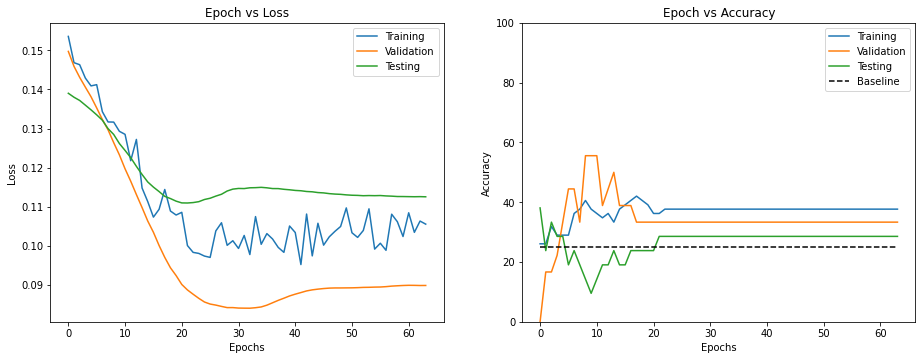

Train/Val/Test Final MSE: [0.09774582237005233, 0.08401339356270102, 0.11483157692211014]
Train/Val/Test Maximum Accuracy: [37.68115942028985, 33.333333333333336, 28.571428571428573]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.12614319622516632 0.11005462167991532 0.12462338920505274
Train/Val/TEST Accuracy: 42.028985507246375 27.77777777777778 14.285714285714286
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10357238054275512 0.08876013631621997 0.11257282289720717
Train/Val/TEST Accuracy: 42.028985507246375 27.77777777777778 14.285714285714286
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.10057150572538376 0.08933109603822231 0.11478557459832657
Train/Val/TEST Accuracy: 53.6231884057971 33.333333333333336 19.047619047619047
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.10284628719091415 0.08964678024252255 0.11402392768788905
Train/Val/TEST Accuracy: 42.028985507246375 27.77777777777778 14.285714285714286
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09685206264257432 0.08842977922823694 0.11328825447708368
Train/Val/TEST Accuracy: 42.028985507246375 27.77777777777778 14.285714285714286
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.10062282234430313 0.0887411209858126 0.113578878

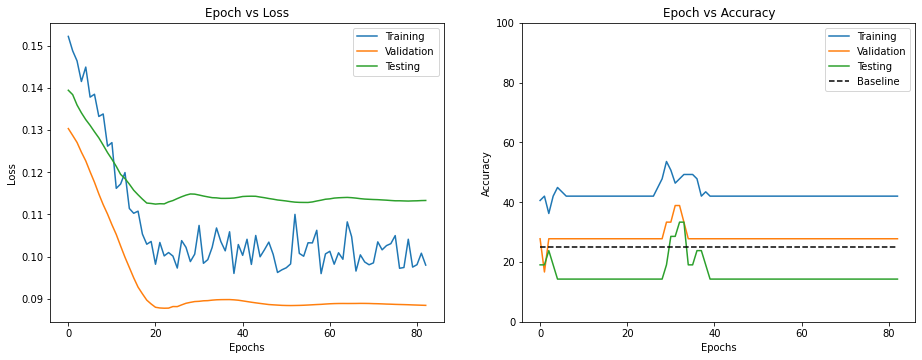

Train/Val/Test Final MSE: [0.09824761897325515, 0.08838377665314409, 0.11301035740013633]
Train/Val/Test Maximum Accuracy: [42.028985507246375, 27.77777777777778, 14.285714285714286]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.13124157041311263 0.13892316818237305 0.12988663606700443
Train/Val/TEST Accuracy: 35.714285714285715 41.1764705882353 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10098154842853546 0.11599879668039434 0.11410027298898924
Train/Val/TEST Accuracy: 35.714285714285715 41.1764705882353 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.09463480859994888 0.11040731004494078 0.11540294518428189
Train/Val/TEST Accuracy: 35.714285714285715 41.1764705882353 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09292724579572678 0.11025556045420029 0.11622485868810188
Train/Val/TEST Accuracy: 40.0 41.1764705882353 14.285714285714286
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.0944732278585434 0.11167804710566998 0.11475489528051444
Train/Val/TEST Accuracy: 35.714285714285715 41.1764705882353 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.0978289321064949 0.11253283983644317 0.11500546185388452
Train/Val/

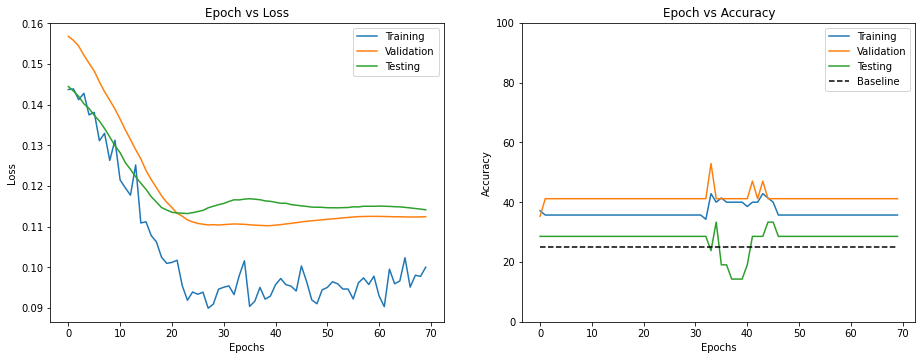

Train/Val/Test Final MSE: [0.09219272136688232, 0.11023698790984995, 0.11634171603336221]
Train/Val/Test Maximum Accuracy: [40.0, 41.1764705882353, 14.285714285714286]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11919237971305847 0.12386689378934748 0.12173213818598361
Train/Val/TEST Accuracy: 38.57142857142857 41.1764705882353 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09797659367322922 0.10229861319941633 0.11360635714871543
Train/Val/TEST Accuracy: 47.142857142857146 41.1764705882353 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.09501571506261826 0.10332310900968664 0.11911565535480068
Train/Val/TEST Accuracy: 38.57142857142857 41.1764705882353 14.285714285714286
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09987503737211227 0.1014751759083832 0.1145249642431736
Train/Val/TEST Accuracy: 38.57142857142857 41.1764705882353 14.285714285714286
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09377081096172332 0.10250039486324086 0.11339773126833495
Train/Val/TEST Accuracy: 38.57142857142857 41.1764705882353 14.285714285714286
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09556987285614013 0.10236547142267227 0.11343886565771841


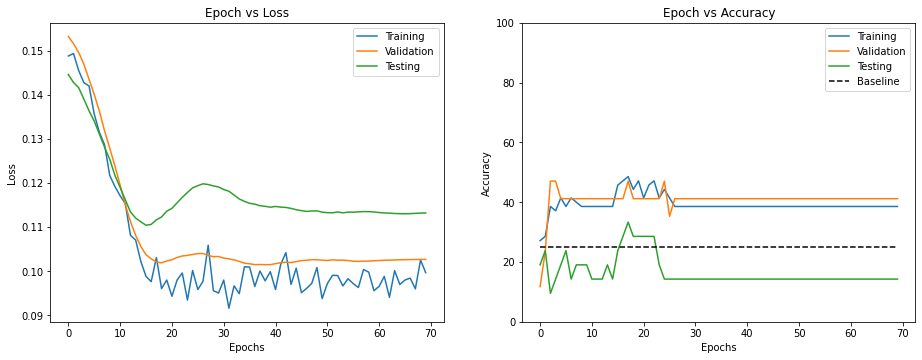

Train/Val/Test Final MSE: [0.09780040234327317, 0.10146673275705646, 0.11471845848219735]
Train/Val/Test Maximum Accuracy: [38.57142857142857, 41.1764705882353, 14.285714285714286]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.10987902879714966 0.12901795962277582 0.11791533763919558
Train/Val/TEST Accuracy: 37.142857142857146 41.1764705882353 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09970048666000367 0.1154288200332838 0.11481819612284501
Train/Val/TEST Accuracy: 38.57142857142857 35.294117647058826 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.09247455447912216 0.11798859278068823 0.11515749880068359
Train/Val/TEST Accuracy: 37.142857142857146 35.294117647058826 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08915121704339982 0.11783369871623375 0.11589515067282177
Train/Val/TEST Accuracy: 47.142857142857146 23.529411764705884 19.047619047619047
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09239929765462876 0.11772774422869962 0.11519837432673999
Train/Val/TEST Accuracy: 42.857142857142854 35.294117647058826 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.0982730507850647 0.11905937050195302 0.1146565

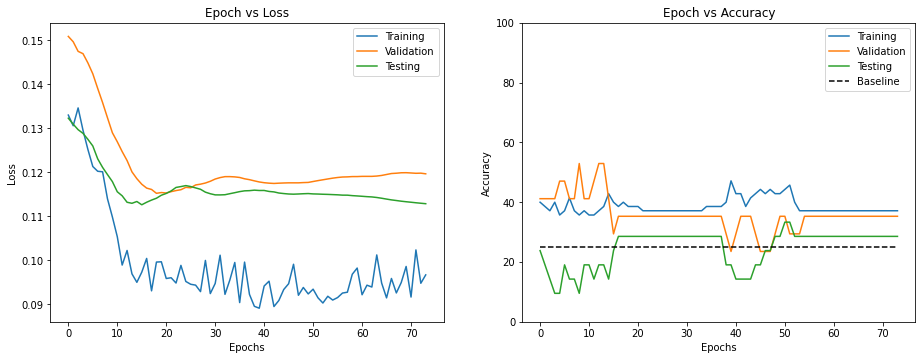

Train/Val/Test Final MSE: [0.08953121155500413, 0.11749652071910746, 0.1155743735531966]
Train/Val/Test Maximum Accuracy: [38.57142857142857, 35.294117647058826, 14.285714285714286]


In [9]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [10]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.09510355532169341, 0.1003194823203718, 0.11489529647820054]
Train/Val/Test Average Accuracy: [39.37060041407867, 35.751633986928105, 17.142857142857146]


## Single prediction results

In [11]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', flabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.19855566 0.12447513 0.4384436  0.42026615] with label  [2]
Target Example: [0.         1.         0.11111111 0.        ] with label  [1]
------- MSE: 0.2724345922470093  Accuracy: 0.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.19760972 0.1172993  0.44064036 0.42195055] with label  [2]
Target Example: [1. 0. 1. 0.] with label  [0, 2]
------- MSE: 0.2871287167072296  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.3382871  0.2719077  0.48006073 0.46088853] with label  [2]
Target Example: [0.7777778  0.         0.22222222 0.        ] with label  [0]
------- MSE: 0.13649620115756989  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.22166273 0.14693214 0.4445419  0.42392096] with label  [2]
Target Example: [0.         0.         0.44444445 0.7777778 ] with label  [3]
------- MSE: 0.04898452013731003  Accuracy: 0.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.25344914 0.17652218 0.45825386 0.43729186] with l

## 2D emotion plot

In [12]:
# Plot 2D emotions in a plane for all dataset
if Is_2D_to_quardrant_emotion:
    fold = 0 # select the model trained in the corresponding fold
    TwoD_emotion_plotting(args, models_K[fold], FullDataset, LabelRange, subject = 27, game = 4, plot_disk = True)
